### ARIMA Model

In [ ]:
import pandas as pd 
import numpy as np
import yfinance as yf 
import matplotlib.pyplot as  plt 
import matplotlib.dates as mdates
%matplotlib inline  
from statsmodels.tsa.arima.model import ARIMA 

import warnings 
warnings.filterwarnings('ignore') 
warnings.filterwarnings('ignore', 'statsmodels.tsa.aima.model.ARIMA',
                        FutureWarning) 

In [ ]:
data = yf.download('SPY',period='10y')  

In [ ]:
data_arima = data.copy() 
data_lstm = data.copy() 

In [ ]:
data.columns

In [ ]:
data.isna().sum() 

In [ ]:
data.head() 

In [ ]:
# Setting rolling window 
rolling_window = int(len(data_arima)*0.70)

# Defining function to select the best model and forecast the price
def select_model_forecast(price_df):
    # The p, d and q values
    aic = []
    p = range(1,3)
    d = range(0,2)
    q = range(1,3)
    # Empty list to store p, q, d
    p_q_d = []
    # Get the aic score for different values of p, d and q
    for i in p:
        for j in d:
            for k in q:
                # Try to fit the model
                try:
                    model = ARIMA(price_df, order=(i, j, k)) 
                    model_fit = model.fit()
                    # Calculate AIC score
                    aic_temp = model_fit.aic 
                    keys_temp = (i, j, k) 
                    # Save AIC score and p, d, and q values
                    p_q_d.append(keys_temp)
                    aic.append(aic_temp) 
                except Exception as e:
                    print('Model not fitting, error : ', e) 
                    pass   

    # Store values in dictionary
    aic_dict = {'p_q_d':p_q_d, 'aic':aic}

    # Create DataFrame for dictionary
    df = pd.DataFrame(aic_dict) 

    # Get minimum AIC value with p, d, and q values
    df = df[df['aic'] == df['aic'].min()].reset_index()

    if len(df)>0:
        # Fitting optimized model
        model_o = ARIMA(price_df, order=df.p_q_d[0]) 
        model_oFit = model_o.fit()

        # making the forecast 
        predicted_price = model_oFit.forecast() 
        print(predicted_price) 
        return predicted_price 
    else:
        return -1 

In [ ]:
def select_model(price_df):
    aic = [] 
    p = range(0,16)
    d = range(0,2) 
    q = range(0,16) 

    p_q_d = []

    # Get aic score for different values of p, q, d
    for i in p:
        for j in d:
            for k in q:
                try:
                    model = ARIMA(price_df, order=(i, j, k)) 
                    model_fit = model.fit() 

                    # Calculate AIC score
                    aic_temp = model_fit.aic
                    keys_temp = (i, j, k) 
                    print(keys_temp, aic_temp)
                    p_q_d.append(keys_temp)
                    aic.append(aic_temp) 
                except:
                    pass 

    # Store values in dictionary
    aic_dict = {'p_q_d':p_q_d, 'aic':aic} 
    print(aic_dict) 

    df = pd.DataFrame(aic_dict)
    df = df[df['aic']==df['aic'].min()].reset_index()
    return df                

In [ ]:
data_arima['Returns'] = data_arima['Adj Close'].pct_change()
data_arima.dropna(inplace=True)
data_df = pd.DataFrame(data_arima['Returns'])  

Time of execution : 30 minutes

In [ ]:
df = select_model(data_df['Returns']) 
df 

### Forecasting the Closing price

Execution time : 5 mins

In [ ]:
data_arima['predicted'] = data_arima['Close'].rolling(rolling_window).apply(select_model_forecast, raw=False) 

### Generating signals for strategy

When predicted_price>close, asset is bought 

In [ ]:
# Defining signal
data_arima['signal'] = np.where(data_arima['predicted_new']>data_arima['Close'],1 ,-1)

# Calculate strategy returns 
data_arima['strategy_returs'] = data_arima['Close'].pct_change()*data_arima['signal'].shift(1) 
data_arima.dropna(inplace=True) 

In [ ]:
data_arima.head() 

In [ ]:
def analyse_strategy(strategy_returns, returns):
    sharpe_ratio = strategy_returns.mean()/strategy_returns.std()*np.sqrt(252)

    # Cumulative Returns
    cumulative_returns = (returns+1).cumprod()
    cumulative_strategy_returns = (strategy_returns+1).cumprod()

    # Calculate running maximum 
    running_max = np.maximum.accumulate(cumulative_strategy_returns.dropna()) 
    # Ensuring that value never drops below 1
    running_max[running_max<1] = 1
    # Calculate percentage drawdown 
    drawdown = 100*((cumulative_strategy_returns)/running_max-1)
    # Calculate maximum drawdown
    max_dd = drawdown.min()

    # Print statistics
    print('Sharpe Ratio %.2f' % sharpe_ratio)
    print('Cumulative Return %.2f' % (((cumulative_strategy_returns[-1])-1)*100)+'%') 
    print('Maximum drawdown %.2f' % max_dd+'%') 

    # Plot
    labels = strategy_returns.index
    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,7)) 

    # Plot returns and strategy returns
    ax1.plot(cumulative_returns, label='Cumulative Returns', color='olive')
    ax1.plot(cumulative_strategy_returns, label = 'Cumulative Strategy Returns', color='b')
    ax1.set_title('Cumulative Returns vs Cumulative Strategy Returns')
    ax1.set_xlabel('Date') 
    ax1.set_ylabel('Cumulative Returns')
    ax1.set_xticklabels(labels, rotation=45, ha='right') 
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y')) 
    ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%d-%m-%Y')) 
    ax1.legend() 
    # Plot max DD
    ax2.plot(drawdown, color='red') 
    ax2.fill_between(drawdown.index, drawdown.values, color='red')
    ax2.set_title('Strategy Drawdown')
    ax2.set_xlabel('Date') 
    ax2.set_ylabel('Drawdown (%)') 
    ax2.set_xticklabels(labels, rotation=45, ha='right') 
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y')) 
    ax2.xaxis.set_minor_formatter(mdates.DateFormatter('%d-%m-%Y')) 
    
    plt.tight_layout()
    plt.show() 

In [ ]:
analyse_strategy(data_arima['strategy_returs'], data_arima['Returns'])

# LSTM

In [1]:
import pandas as pd 
import numpy as  np 
import matplotlib.pyplot as plt 
%matplotlib inline 
import talib as ta 
import yfinance as yf
import datetime, random, pickle 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, recall_score, precision_score, f1_score 
from keras.callbacks import EarlyStopping
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
import keras.backend as K
from statistics import mean 

In [2]:
def classify_return(future):
    if float(future)>0:
        return 1.0
    else:
        return 0.0 

In [3]:
def threshold_longshort(predict):
    if float(predict)>0.5:
        return 1.0
    else:
        return -1.0

In [4]:
def recall(y_true, y_pred): #Sensitivity
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    all_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (all_positives + tf.keras.backend.epsilon())
    return recall 

In [5]:
def precision(y_true, y_pred): #ppv
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision  

In [6]:
def f1score(y_true,y_pred):
    return 2*recall(y_true, y_pred)*precision(y_true, y_pred)/(precision(y_true, y_pred)+recall(y_true, y_pred))

In [7]:
future_period = 3
tickers = ['SPY','TLT'] 
train_df = pd.DataFrame()  

In [8]:
for ticker in tickers:    
    df = yf.download(ticker,period='5y')
    df.rename(columns={'Adj Close':f'{ticker}_close','Volume':f'{ticker}_volume'}, inplace=True)
    # df.set_index('Date', inplace=True)
    df = df[[f'{ticker}_close',f'{ticker}_volume']] 

    if len(train_df)==0:
        train_df = df
    else:
        train_df = train_df.join(df)    

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [9]:
train_df.shape 

(1258, 4)

In [10]:
train_df.head() 

,SPY_close,SPY_volume,TLT_close,TLT_volume
Date,,,,
2019-06-26,268.471191,51584900,117.450500,12766800
2019-06-27,269.423187,40355200,118.278198,9724200
2019-06-28,270.809479,59350900,118.198143,8149200
2019-07-01,273.268097,78705600,117.921677,14131200
2019-07-02,273.979736,61504500,118.831161,10494300


In [11]:
train_df['future'] = train_df['SPY_close'].pct_change()

In [12]:
for k in range(future_period):
    if k==0:
        temp_series = train_df['future'].shift(-1)
    else:
        temp_series+=train_df['future'].shift(-k-1) 

train_df['future'] = temp_series/future_period 

In [13]:
train_df['target'] = list(map(classify_return, train_df['future'])) 
train_df['SPY_true_return'] = train_df['SPY_close'].pct_change().shift(-1)  

In [14]:
train_df = train_df.drop(['future'],axis=1) 
train_df.head()

,SPY_close,SPY_volume,TLT_close,TLT_volume,target,SPY_true_return
Date,,,,,,
2019-06-26,268.471191,51584900,117.450500,12766800,1.0,0.003546
2019-06-27,269.423187,40355200,118.278198,9724200,1.0,0.005145
2019-06-28,270.809479,59350900,118.198143,8149200,1.0,0.009079
2019-07-01,273.268097,78705600,117.921677,14131200,1.0,0.002604
2019-07-02,273.979736,61504500,118.831161,10494300,1.0,0.007995


In [15]:
print('Before dropping NaN values : ',train_df.shape) 
train_df = train_df.dropna()
print('After dropping NaN values : ',train_df.shape)  

Before dropping NaN values :  (1258, 6)
After dropping NaN values :  (1257, 6)


#### Selecting last 10% as validation dataset
Here, last_valdata is the index of boundary that seperates 90% and 10% data

In [16]:
last_valdata = sorted(train_df.index.values)[-int(0.10*len(train_df.index.values))]

validation_df = train_df[(train_df.index >= last_valdata)]
train_df =  train_df[(train_df.index < last_valdata)] 

In [17]:
for ticker in tickers:
    train_df[f'{ticker}_close'] = train_df[f'{ticker}_close'].pct_change()
    validation_df[f'{ticker}_close'] = validation_df[f'{ticker}_close'].pct_change()
    train_df[f'{ticker}_volume'] = train_df[f"{ticker}_volume"].pct_change()
    validation_df[f"{ticker}_volume"]=validation_df[f"{ticker}_volume"].pct_change() 

In [18]:
train_df.dropna(inplace=True)
validation_df.dropna(inplace=True) 

In [19]:
print('Shape and Null values in train_df : ',train_df.shape, train_df.isna().sum().sum()) 
print('Shape and Null values in validation_df : ',validation_df.shape, validation_df.isna().sum().sum())  

Shape and Null values in train_df :  (1131, 6) 0
Shape and Null values in validation_df :  (124, 6) 0


In [20]:
col_names = []
for ticker in tickers:
    col_names.append(f'{ticker}_close')
    col_names.append(f'{ticker}_volume') 
col_names     

['SPY_close', 'SPY_volume', 'TLT_close', 'TLT_volume']

In [21]:
scaler = StandardScaler()
train_df[col_names] = scaler.fit_transform(train_df[col_names])
validation_df[col_names] = scaler.fit_transform(validation_df[col_names]) 

In [22]:
train_x = []
hist_days = deque(maxlen=len(train_df)) 
for i in train_df.values:  
    hist_days.append([n for n in i[:-2]])
    if len(hist_days) == len(train_df):  
        train_x.append(np.array(hist_days))        

In [23]:
train_y = []
hist_days = deque(maxlen=len(train_df)) 
for i in train_df.values:  
    hist_days.append([n for n in i[-2:-1]]) 
    if len(hist_days) == len(train_df):  
        train_y.append(np.array(hist_days))   
print(type(train_y))         

<class 'list'>


In [24]:
validation_x = []
hist_days = deque(maxlen=len(validation_df)) 
for i in validation_df.values:  
    hist_days.append([n for n in i[:-2]]) 
    if len(hist_days) == len(validation_df):  
        validation_x.append(np.array(hist_days))
print(type(validation_x))            

<class 'list'>


In [25]:
validation_y = []
hist_days = deque(maxlen=len(validation_df)) 
for i in validation_df.values:  
    hist_days.append([n for n in i[-2:-1]]) 
    if len(hist_days) == len(validation_df):  
        validation_y.append(np.array(hist_days))
print(type(validation_y))            

<class 'list'>


In [26]:
val_y_true=[] 
hist_days = deque(maxlen=len(validation_df)) 
for i in validation_df.values:  
    hist_days.append([n for n in i[-1:]]) 
    if len(hist_days) == len(validation_df):  
        val_y_true.append(np.array(hist_days))             

In [27]:
val_y_true_data = np.array(val_y_true) # Only to get the size for for loop 

In [28]:
# Build base model
model = Sequential()
model.add(LSTM(32, input_shape=(4,1), return_sequences=True))
model.add(Dropout(0.2)) 
model.add(BatchNormalization())                                                    

model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(BatchNormalization())                                                                                 

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))        

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(),metrics=[precision, recall,f1score]) 
model.fit(train_x, train_y, batch_size=128, epochs=50, validation_data=(validation_x, validation_y))  

c:\Users\vidya\.conda\envs\pyten\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - f1score: 0.5561 - loss: 0.7800 - precision: 0.5920 - recall: 0.5283 - val_f1score: 0.7600 - val_loss: 0.6866 - val_precision: 0.6129 - val_recall: 1.0000
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - f1score: 0.6360 - loss: 0.7423 - precision: 0.5759 - recall: 0.7161 - val_f1score: 0.7600 - val_loss: 0.6853 - val_precision: 0.6129 - val_recall: 1.0000
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1score: 0.6975 - loss: 0.6921 - precision: 0.6114 - recall: 0.8158 - val_f1score: 0.7600 - val_loss: 0.6848 - val_precision: 0.6129 - val_recall: 1.0000
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1score: 0.6688 - loss: 0.7226 - precision: 0.5708 - recall: 0.8104 - val_f1score: 0.7600 - val_loss: 0.6849 - val_precision: 0.6129 - val_recall: 1.0000
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - f1score: 0.7008 - loss: 0.6806 - precision: 0.6086 - recall: 0.8281 - val_f1score: 0.7600 - val_loss: 0.6848 - val_precision: 0.6

In [29]:
y_pred_val=list(map(threshold_longshort, model.predict(validation_x)))    

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step


C:\Users\vidya\AppData\Local\Temp\ipykernel_10128\2120555642.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if float(predict)>0.5:


In [32]:
print('Shape before flatten: ',val_y_true_data.shape )
val_y_true_flat = val_y_true_data.flatten()
print('Shape after flatten: ',val_y_true_flat.shape) 

Shape before flatten:  (1, 124, 1)
Shape after flatten:  (124,)


In [33]:
returns = []
for i in range(val_y_true_flat.shape[0]): 
    if i==0:
        returns.append(0)
    else: 
        # print(val_y_true_flat[i]*y_pred_val[i-1])
        returns.append(val_y_true_flat[i]*y_pred_val[i-1])     

0.0003776780418438541
-0.002894975370321351
-0.005596381574313969
-0.008166640372830103
-0.0032211369580344984
0.0013697381395338937
0.014275908664113324
-0.001517050838674705
0.005655394244438616
-0.0004405996640692855
0.0006926853037954039
-0.0036712550643804853
-0.0055586335904656
0.00889283322488077
0.012466154983796773
0.00211431631440151
0.00291649570504382
0.001093126138066003
0.005438909672036862
-0.0012704071897948754
0.007919333517319327
-0.0007734208293256328
-0.016317346482071504
0.013088239371998656
0.010527359231231825
-0.0036411682179211535
0.002903265751540207
0.0083404057853953
0.0004417079324061657
0.00577941881764521
-0.00043897588714769675
-0.013773062715358275
0.009087663299097493
0.0068997692890413465
-0.004980002053079358
-0.0055053946645677865
0.0009057676459622854
0.020695519627352388
0.0006896848454327476
-0.0036625404805514794
0.0018577582803256387
-0.0013216102695812193
0.0035949388773643953
0.009388215844884806
-0.0010723904258075345
-0.00999410475268192
0.

In [35]:
returns_d = np.array(returns)

array([ 0.00000000e+00,  3.77678042e-04, -2.89497537e-03, -5.59638157e-03,
       -8.16664037e-03, -3.22113696e-03,  1.36973814e-03,  1.42759087e-02,
       -1.51705084e-03,  5.65539424e-03, -4.40599664e-04,  6.92685304e-04,
       -3.67125506e-03, -5.55863359e-03,  8.89283322e-03,  1.24661550e-02,
        2.11431631e-03,  2.91649571e-03,  1.09312614e-03,  5.43890967e-03,
       -1.27040719e-03,  7.91933352e-03, -7.73420829e-04, -1.63173465e-02,
        1.30882394e-02,  1.05273592e-02, -3.64116822e-03,  2.90326575e-03,
        8.34040579e-03,  4.41707932e-04,  5.77941882e-03, -4.38975887e-04,
       -1.37730627e-02,  9.08766330e-03,  6.89976929e-03, -4.98000205e-03,
       -5.50539466e-03,  9.05767646e-04,  2.06955196e-02,  6.89684845e-04,
       -3.66254048e-03,  1.85775828e-03, -1.32161027e-03,  3.59493888e-03,
        9.38821584e-03, -1.07239043e-03, -9.99410475e-03,  5.06723780e-03,
        9.92637576e-03, -6.00216084e-03, -8.59842751e-04,  1.07574341e-02,
       -1.56758926e-03, -

In [36]:
equity_bm=10000*np.cumprod(1+np.array(val_y_true_flat))
equity_stgy=10000*np.cumprod(1+np.array(returns_d))  

In [37]:
ann_return_stgy = 252*np.array(returns_d).mean()
ann_return_bm = 252*np.array(val_y_true_flat).mean() 

In [38]:
sharpe_ratio_stgy=np.sqrt(252)*np.array(returns_d).mean()/np.array(returns_d).std()
sharpe_ratio_bm=np.sqrt(252)*np.array(val_y_true_flat).mean()/np.array(val_y_true_flat).std()

In [39]:
win_ratio_bm=len((np.where(np.array(val_y_true_flat)>0))[0]) / len(val_y_true_flat)
win_ratio_stgy=len((np.where(np.array(returns_d)>0))[0]) / len(returns_d)

In [40]:
Roll_Max = pd.Series(equity_bm).rolling(window=2*252, min_periods=1).max()
DD_bm = (pd.Series(equity_bm)/Roll_Max-1).min() 

In [41]:
Roll_Max = pd.Series(equity_stgy).rolling(window=2*252, min_periods=1).max()
DD_stgy = (pd.Series(equity_stgy)/Roll_Max-1).min()      

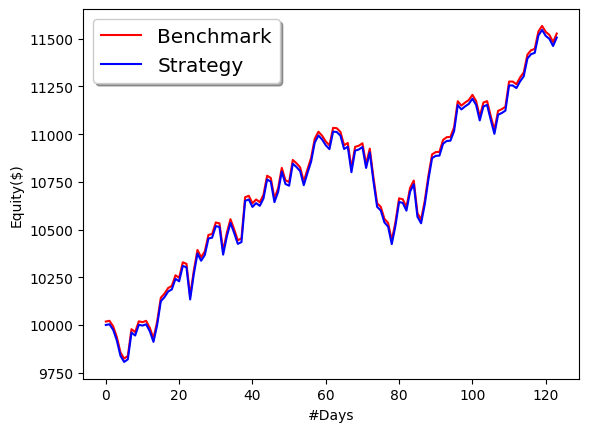

In [42]:
fig, ax = plt.subplots()
ax.plot(equity_bm,label='Benchmark',color='r')
ax.plot(equity_stgy,label='Strategy',color='b')
ax.legend(loc='upper left', shadow=True, fontsize='x-large')
plt.xlabel('#Days')
plt.ylabel('Equity($)')                                         
plt.show() 

In [43]:
print ('Annual Return% Benchmark vs Strategy')
print (100*ann_return_bm, 100*ann_return_stgy) 

Annual Return% Benchmark vs Strategy
29.464280238649028 29.096822333796784


In [44]:
print ('Sharpe Ratio Benchmark vs Strategy')
print ([sharpe_ratio_bm, sharpe_ratio_stgy]) 

Sharpe Ratio Benchmark vs Strategy
[2.767420144154994, 2.7326783988508074]


In [45]:
print ('%Winners Benchmark vs Strategy')
print ([100*win_ratio_bm, 100*win_ratio_stgy]) 

%Winners Benchmark vs Strategy
[57.25806451612904, 56.451612903225815]


In [47]:
print ('Max Drawdown(%) Benchmark vs Strategy')
print ([100*DD_bm, 100*DD_stgy]) 

Max Drawdown(%) Benchmark vs Strategy
[-5.353899373049298, -5.353899373049254]
